In [1]:
__author__ = "Ilan Fridman Rojas"

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import seaborn as sns

%matplotlib inline

In [2]:
#os.chdir("/home/ilan/Desktop/Boris_proyecto")
os.listdir()

['evaluating-machine-learning-models.pdf',
 'tree.dot',
 '__pycache__',
 'tree.png',
 'Deep_MLP.ipynb',
 'LasagneUpdateRules_Feb_2017.py',
 '.ipynb_checkpoints',
 'Rule_Extraction_w_pretraining.ipynb',
 'Regression_toolkit.ipynb']

In [3]:
df = pd.read_csv("../data/wyflows_w_response_and_geo.csv")

In [4]:
df.describe()

,workhome,metro,train,bus,taxi,motorcycle,car,cycle,walk,othertransp,...,otherqual,centheat,nrooms,wzclass,distance,response,disttrainstn,distcoachstn,distbusstop,distmway
count,53807.0,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,...,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,53807.000000,5.380700e+04,53807.000000
mean,0.0,0.000586,0.040234,0.078933,0.005760,0.006470,0.823709,0.008320,0.033876,0.002112,...,0.050563,0.952235,5.258981,4.115189,14.517468,0.118612,0.693155,1.826619,1.601633e-02,2.359772
std,0.0,0.016080,0.151422,0.173004,0.043271,0.050552,0.260127,0.052078,0.112083,0.029691,...,0.023133,0.024733,0.535409,1.479845,7.955181,0.268266,0.734384,1.757177,3.047258e-02,2.825875
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017214,0.842247,2.900000,1.000000,0.599442,-0.768199,0.000008,0.000011,3.903194e-07,0.000022
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.717391,0.000000,0.000000,0.000000,...,0.036216,0.936194,5.000000,3.000000,8.481763,0.006851,0.196448,0.659839,2.922652e-03,0.476861
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.042466,0.953867,5.200000,4.000000,13.480005,0.232432,0.456020,1.353887,7.658440e-03,1.289197
75%,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.056434,0.973034,5.500000,5.000000,19.379276,0.269903,0.940981,2.434321,1.753587e-02,3.080721
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.140689,0.995994,7.100000,7.000000,56.246358,0.901646,14.221932,16.523315,1.241236e+00,23.216051


In [5]:
#df = df.rename(columns={'Nucleus or nucleic juncture':'Nucleus', 'Uttered beat\nprominence':'Prominence', \
#                  'High boundary':'Upper_bound', 'Low\nboundary':'Lower_bound', 'Fundamental frequency':'Fund_freq',\
#                  'Focal frequency':'Focal_freq', 'Event ID,\nUtterance #':'Event_ID_Utterance'})
#df.head()

In [6]:
df.columns

Index(['homeMSOA', 'workMSOA', 'workhome', 'metro', 'train', 'bus', 'taxi',
       'motorcycle', 'car', 'cycle', 'walk', 'othertransp', 'npeople', '16-24',
       '25-34', '35-49', '50-54', '65-74', '75+', 'female', 'house0carpct',
       'house1carpct', 'house2carpct', 'house3carpct', 'house4carpct',
       'ppperhect', 'econactivpct', 'econinactivpct', 'vghealth', 'ghealth',
       'fhealth', 'bhealth', 'vbhealth', 'white', 'mixed', 'asian', 'black',
       'otherethn', 'noqual', 'aptshpqual', 'lev1qual', 'lev2qual', 'lev3qual',
       'lev4qual', 'otherqual', 'centheat', 'nrooms', 'wzclass', 'distance',
       'response', 'disttrainstn', 'distcoachstn', 'distbusstop', 'distmway'],
      dtype='object')

# In order to apply logit models etc we need to rescale the response to [0,1]
from sklearn.preprocessing import MinMaxScaler

yscaler = MinMaxScaler().fit(df.loc[:, "response"].values.reshape(-1,1))
df.loc[:, "response"] = yscaler.transform(df.loc[:, "response"].values.reshape(-1,1))

df.loc[:, "response"].describe()

df.loc[:,"response"].hist()

In [7]:
Xfull = df.drop(['homeMSOA','workMSOA','car','response','distance','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).values
Yfull = df['response'].values

predictors = list(df.drop(['homeMSOA','workMSOA','car','response','distance','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).columns)

In [8]:
# TO PREDICT CAR FRACTION DIRECTLY, INCLUDING DISTANCE AS A COVARIATE
#Xfull = df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).values
#Yfull = df['car'].values

#predictors = list(df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).columns)

In [9]:
# DO NOT USE THE FULL DATASET, SPLIT OFF A TRAINING SET BEFORE GOING FURTHER, AND NEVER USE THE FULL SET

import math

idx = list(range(Xfull.shape[0]))
np.random.seed(seed=5)
np.random.shuffle(idx)
np.random.seed(seed=None)

trainsetsize = math.floor(Xfull.shape[0]/2)
trainidx = idx[:trainsetsize]

X, Y = Xfull[trainidx,:], Yfull[trainidx]

In [10]:
predictors

['16-24',
 '25-34',
 '35-49',
 '50-54',
 '65-74',
 '75+',
 'female',
 'house0carpct',
 'house1carpct',
 'house2carpct',
 'house3carpct',
 'house4carpct',
 'ppperhect',
 'econactivpct',
 'econinactivpct',
 'vghealth',
 'ghealth',
 'fhealth',
 'bhealth',
 'vbhealth',
 'white',
 'mixed',
 'asian',
 'black',
 'otherethn',
 'noqual',
 'aptshpqual',
 'lev1qual',
 'lev2qual',
 'lev3qual',
 'lev4qual',
 'otherqual',
 'centheat',
 'nrooms',
 'wzclass',
 'disttrainstn',
 'distcoachstn',
 'distbusstop',
 'distmway']

In [11]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

#cross_valsets = StratifiedKFold(n_splits=2)
cross_valsets = KFold(n_splits=10)
for train_index, test_index in cross_valsets.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# We use X = X_train + X_test for the cross-validation runs, so scale X too (note: X is already a training set)
X = scaler.transform(X)

In [13]:
from sklearn.model_selection import cross_val_score

from pprint import pprint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.dummy import DummyRegressor
#from sklearn.linear_model import LogisticRegressionCV # would require Min-Max scaling of response variable
#from sklearn.ensemble import AdaBoostRegressor # Boosted decision trees, superseded by xgboost?
#from sklearn.ensemble import GradientBoostingRegressor # Boosted decision trees, superseded by xgboost?
#from sklearn.ensemble import BaggingRegressor # needs base clasifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

result = []

clf = DummyRegressor()
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["Dummy", scores.mean()])

clf = ExtraTreesRegressor(n_jobs=4)
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["ExtraTrees", scores.mean()])

clf = DecisionTreeRegressor()
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["DecisionTrees", scores.mean()])

clf = RandomForestRegressor(n_jobs=4)
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["RandomForest", scores.mean()])

#  THIS MODEL REQUIRES SO MUCH RAM IT WILL CRASH YOUR COMPUTER INSTANTLY
#clf = GaussianProcessRegressor()
#clf = clf.fit(X_train, Y_train)
#Y_pred = clf.predict(X_test)
#scores = mean_squared_error(Y_test, Y_pred)
#result.append(["GaussianProcess", scores.mean()])

clf = ElasticNetCV(n_jobs=4)
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["ElasticNetCV", scores.mean()])

clf = PassiveAggressiveRegressor()
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["PassiveAggressive", scores.mean()])

clf = RANSACRegressor()
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["RANSAC", scores.mean()])

clf = SGDRegressor(learning_rate='optimal')
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["SGD", scores.mean()])

clf = TheilSenRegressor(n_jobs=4)
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["TheilSen", scores.mean()])

clf = KNeighborsRegressor(n_jobs=4)
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["KNeighbors", scores.mean()])

#clf = RadiusNeighborsRegressor(n_jobs=4)
#clf = clf.fit(X_train, Y_train)
#Y_pred = clf.predict(X_test)
#scores = mean_squared_error(Y_test, Y_pred)
#result.append(["RadiusNeighbors", scores.mean()])

clf = MLPRegressor()
#scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, n_jobs=4, scoring='r2')
result.append(["MLP", scores.mean()])

clf = xgb.XGBRegressor()
#scores = cross_val_score(clf, X, Y, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, X, Y, scoring='r2')
result.append(["XGB", scores.mean()])

# Model which simply always predicts the sample mean of the response
#result.append(["--MEAN MODEL--", mean_squared_error(Y_test, np.repeat(Y_test.mean(), Y_test.shape[0]))])
result.append(["--MEAN MODEL--", r2_score(Y_test, np.repeat(Y_test.mean(), Y_test.shape[0]))])

result.sort(key=lambda x: x[1], reverse=True)
pprint(result)

[['XGB', 0.18683495340829917],
 ['ElasticNetCV', 0.14689197361179665],
 ['MLP', 0.13340324462831601],
 ['TheilSen', 0.11365649905324675],
 ['RandomForest', 0.076390502533061413],
 ['KNeighbors', 0.040983543493443464],
 ['ExtraTrees', 0.014137692731478838],
 ['--MEAN MODEL--', 0.0],
 ['Dummy', -0.00010168044681220974],
 ['DecisionTrees', -0.64397242306936631],
 ['PassiveAggressive', -0.66751228560464915],
 ['RANSAC', -6.3113232476419131e+22],
 ['SGD', -8.4825178804993412e+25]]


In [14]:
# HOW TO PREDICT FROM A MODEL
#clf = xgb.XGBRegressor()
#clf = clf.fit(X_train, Y_train)
#Y_pred = clf.predict(X_test)
#scores = mean_squared_error(Y_test, Y_pred)

In [15]:
#from sklearn.feature_selection import f_regression
#from sklearn.feature_selection import mutual_info_regression

#f_regression(X, Y)

#mutinfo = mutual_info_regression(X, Y)

In [16]:
#mutinfofeats = []
#for i, row in enumerate(mutinfo):
#    mutinfofeats.append([predictors[i], row])
    
#mutinfofeats.sort(key=lambda x: x[1], reverse=True)
#pprint(mutinfofeats[:15])

0.122358184585


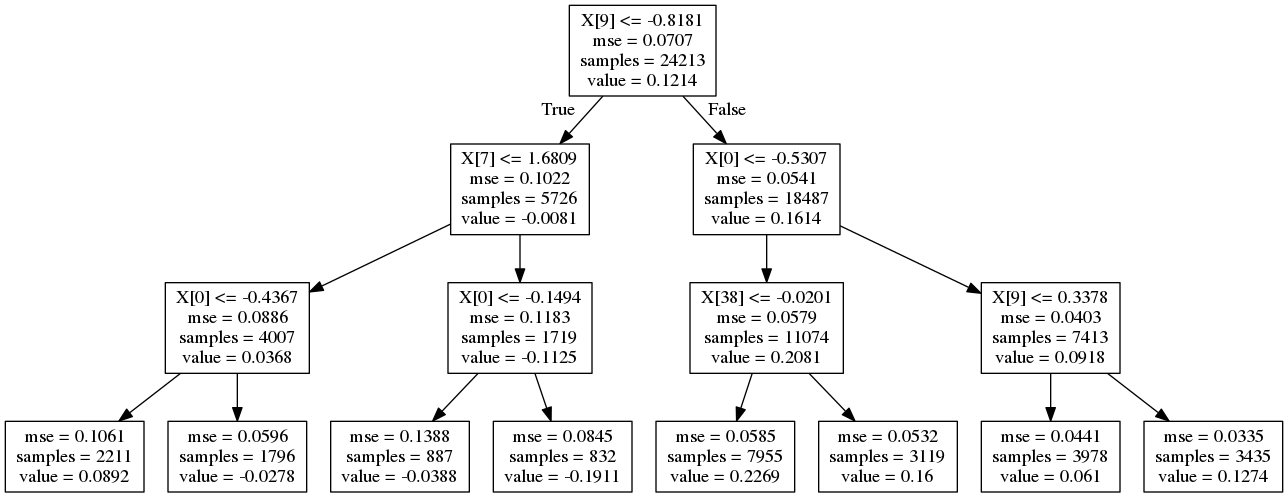

In [17]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(r2_score(Y_test,Y_pred))

tree.export_graphviz(clf, out_file='tree.dot')

# sudo apt-get install graphviz
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image(filename='tree.png') 

Feature ranking:
1. distmway (0.093115)
2. distbusstop (0.088437)
3. disttrainstn (0.085930)
4. distcoachstn (0.083002)
5. house2carpct (0.077227)
6. 16-24 (0.077043)
7. female (0.048584)
8. house0carpct (0.037001)
9. wzclass (0.035823)
10. 35-49 (0.033814)
11. 25-34 (0.033478)
12. 50-54 (0.026364)
13. centheat (0.015482)
14. ppperhect (0.015011)
15. black (0.014646)
16. house1carpct (0.013726)
17. house3carpct (0.012994)
18. mixed (0.011990)
19. lev1qual (0.011834)
20. ghealth (0.011783)
21. white (0.011597)
22. house4carpct (0.011515)
23. otherqual (0.011348)
24. otherethn (0.011142)
25. bhealth (0.010810)
26. lev3qual (0.010214)
27. lev2qual (0.010151)
28. lev4qual (0.009983)
29. aptshpqual (0.009880)
30. vbhealth (0.009831)
31. vghealth (0.009433)
32. asian (0.009182)
33. fhealth (0.008309)
34. noqual (0.007853)
35. econactivpct (0.007669)
36. nrooms (0.007276)
37. econinactivpct (0.006927)
38. 65-74 (0.006767)
39. 75+ (0.002827)


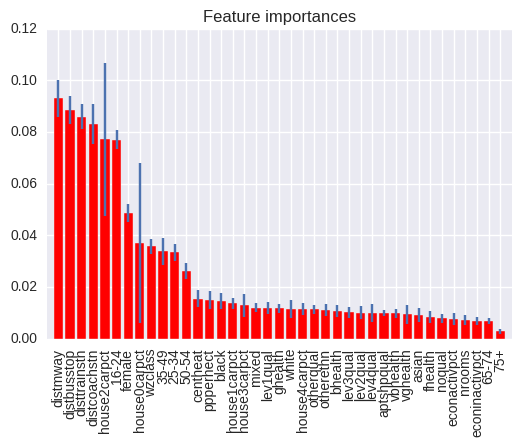

In [18]:
clf = RandomForestRegressor(n_jobs=4)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

scores = r2_score(Y_test, Y_pred)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
    
randforestfeats = [[predictors[indices[f]], importances[indices[f]]] for f in range(X.shape[1])]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.asarray(predictors)[indices], rotation="vertical")
plt.xlim([-1, X.shape[1]])
plt.show()

import seaborn as sns

#sns.boxplot(x="IPA tags", y="Prominence", data=df_sub)
#sns.boxplot(x="IPA tags", y="Prominence", data=df_sub)

#for i in predictors:
#    sns.boxplot(x="car", y=i, data=df.iloc[trainidx,:])
#    plt.show()


sns.pairplot(data=df.loc[trainidx, predictors])

In [49]:
# We now test the Boruta feature selection method
# https://www.jstatsoft.org/article/view/v036i11

# git clone https://github.com/scikit-learn-contrib/boruta_py.git && cd boruta_py && sudo python3 setup.py install
# or
# sudo pip3 install git+https://github.com/scikit-learn-contrib/boruta_py.git

from boruta import BorutaPy

clfbor = RandomForestRegressor(n_jobs=4)

boruta = BorutaPy(clfbor, n_estimators='auto', verbose=2, random_state=1)
boruta.fit(X_train, Y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	31


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	31


BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=88, n_jobs=4, oob_score=False,
           random_state=<mtrand.RandomState object at 0x7ff11c5d30d8>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7ff11c5d30d8>,
     two_step=True, verbose=2)

In [50]:
#borutafeats.support_

In [51]:
#borutafeats.ranking_

In [52]:
borutafeats = list(np.asarray(predictors)[boruta.support_])
borutafeats

['16-24',
 'female',
 'house0carpct',
 'house2carpct',
 'disttrainstn',
 'distcoachstn',
 'distbusstop',
 'distmway']

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Using%20lime%20for%20regression.ipynb

In [53]:
# HOW TO PREDICT FROM A MODEL
clf = xgb.XGBRegressor()
#clf = ElasticNetCV()
#clf = MLPRegressor()
#clf = RandomForestRegressor()
#clf = TheilSenRegressor()
#clf = KNeighborsRegressor()

# We undo the standard scaling of features so that explanation is given in terms of variables with original scale
# For tree-based models this scaling or lackthereof should not affect performance much
clf = clf.fit(scaler.inverse_transform(X_train), Y_train)

#Y_pred = clf.predict(X_test)
#scores = mean_squared_error(Y_test, Y_pred)

In [54]:
# git clone https://github.com/marcotcr/lime.git
# cd lime
# sudo python3 setup.py install

# Or simply:
# sudo pip3 install git+https://github.com/marcotcr/lime.git

import lime
import lime.lime_tabular

In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=predictors, class_names=['response'], categorical_features=None, verbose=True)

In [56]:
predict_fn = lambda x: clf.predict(x).reshape(-1,1)

In [57]:
np.argmin(predict_fn(X_test))

1351

In [58]:
np.argmax(predict_fn(X_test))

1731

In [59]:
i = 1151
exp = explainer.explain_instance(X_test[i], predict_fn, labels=[0], num_features=15)

Intercept -0.134205159085
Prediction_local [ 0.2328269]
Right: 0.233581


In [60]:
limefeats = exp.as_list(0)
exp.as_list(0)

[('16-24 <= -0.55', 0.12988759531232377),
 ('house2carpct > 0.75', 0.10748979570369631),
 ('centheat > 0.84', 0.051017408194899902),
 ('female <= -1.27', 0.046699192807183841),
 ('house0carpct <= -0.74', 0.039957553456623357),
 ('75+ <= -0.09', 0.034109391967011578),
 ('house3carpct > 0.73', 0.031484393120579469),
 ('wzclass > 0.60', -0.023647685159652477),
 ('distcoachstn <= -0.67', -0.021651346327920876),
 ('-0.36 < lev3qual <= -0.13', -0.018506963590171017),
 ('35-49 <= -1.16', 0.015904908698174538),
 ('-0.62 < otherqual <= -0.35', -0.013922246344069312),
 ('-0.57 < lev2qual <= 0.24', -0.012613401459096726),
 ('50-54 > 0.37', 0.011782122414104153),
 ('-0.18 < vbhealth <= 0.56', -0.010958662107143186)]

In [61]:
print('Prediction', predict_fn(X_test[i].reshape(1,-1))[0,0])
print('True', Y_test[i])

Prediction 0.233581
True 0.637004821227


In [62]:
testidx = idx[trainsetsize:]

plotdf = df.loc[testidx, :]

plotdf.loc[:, "prediction"] = clf.predict(plotdf.loc[:, predictors].values)
plotdf.loc[:, "residual"] = plotdf.loc[:, "response"] - plotdf.loc[:, "prediction"]

In [63]:
r2_score(plotdf[["response"]], plotdf[["prediction"]])

0.18545956452521728

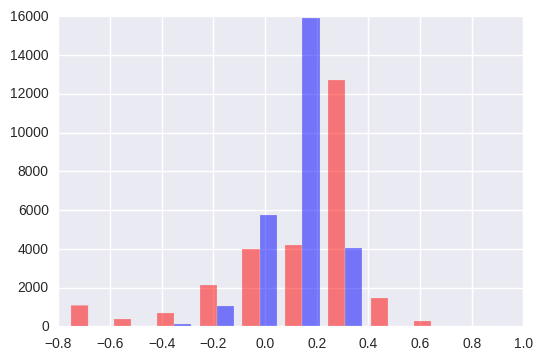

In [64]:
import seaborn as sns
plt.hist([plotdf.loc[:, "response"], plotdf.loc[:, "prediction"]], color=['r','b'], alpha=0.5)
plt.show()

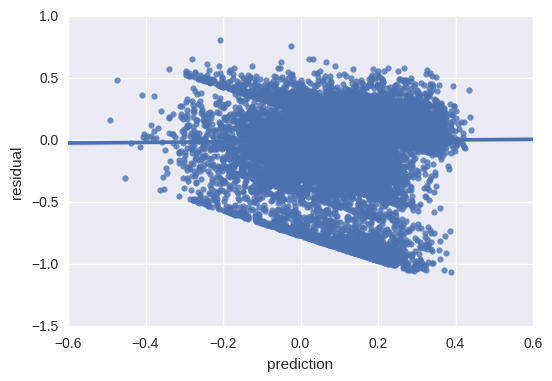

In [65]:
import seaborn as sns

sns.regplot("prediction", "residual", data=plotdf)
plt.show()

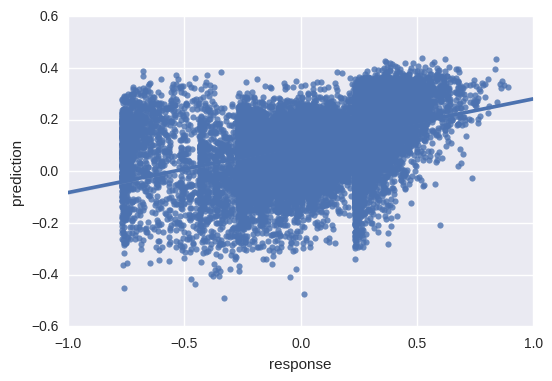

In [66]:
sns.regplot("response","prediction", plotdf)
plt.show()

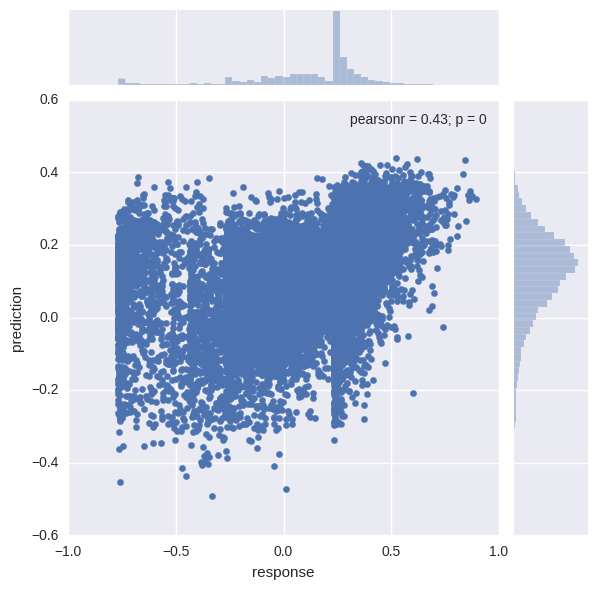

In [67]:
sns.jointplot("response","prediction", plotdf)
plt.show()

In [68]:
clf = ElasticNetCV()
clf = clf.fit(X_train, Y_train)

elasticfeats = []
for i, row in enumerate(clf.coef_):
    elasticfeats.append([predictors[i], row])
    
elasticfeats.sort(key=lambda x: abs(x[1]), reverse=True)
pprint(elasticfeats[:15])

[['house0carpct', -0.054776752111176844],
 ['16-24', -0.039986717012221888],
 ['house2carpct', 0.023393197156165998],
 ['wzclass', 0.019279327583230369],
 ['distmway', -0.01587186133919307],
 ['bhealth', 0.015295607154651159],
 ['female', -0.014358661391721136],
 ['black', -0.014144458679228738],
 ['fhealth', 0.0082149141041498227],
 ['noqual', -0.0077581268478576753],
 ['vbhealth', 0.0072882827055536781],
 ['mixed', 0.0070850099027320521],
 ['otherethn', -0.0062778655952986503],
 ['econactivpct', -0.0052560597618020177],
 ['lev2qual', 0.0046241045861757177]]


In [69]:
elasticfeats_set = set(np.asarray(elasticfeats)[:10,0])
randforestfeats_set = set(np.asarray(randforestfeats)[:10,0])
borutafeats = set(borutafeats)
#limefeats_set = set([i[0].split()[0] for i in limefeats[:10]]) # LIME is for individual predictions, so do not consider here
#mutinfofeats_set = set(np.asarray(mutinfofeats)[:10,0])

impfeats = randforestfeats_set.intersection(elasticfeats_set)
impfeats = impfeats.intersection(borutafeats)
#impfeats = impfeats.intersection(mutinfofeats_set)
impfeats

{'16-24', 'distmway', 'female', 'house0carpct', 'house2carpct'}

for i in predictors:
    sns.regplot(i, "response", data=df.iloc[trainidx, :])
    plt.show()

sns.pairplot(data=df.loc[trainidx, predictors])